# Training & Evaluation of User‑Based Autoencoder

**Description:**  
This notebook loads the preprocessed beer content from `user_beer_likes.csv`, 

---

## Overview

- **Data Source:**  
  `user_beer_likes.csv` containing ...

- **Objectives:**  
  1. Train and validate an autoencoder to learn compact user embeddings.  
  3. Verify embedding quality with reconstruction metrics and manual sanity checks.  
  4. Export the trained model and embeddings for inference.


## Load Preprocessed Beer Content Data

Load`user_beer_likes.csv` into a pandas DataFrame `df`, prints the first few rows for inspection, and catches any exceptions if the file fails to load.


In [1]:
import pandas as pd

try:
    df = pd.read_csv('user_beer_likes.csv')
    print("\final Data Sample:")
    print(df.head())
except Exception as e:
    print(f"Error loading reviews.csv: {e}")

inal Data Sample:
   username  6  7  10  17  30  31  33  34  39  ...  76816  77299  82250  \
0   --Dom--  0  0   0   0   0   0   0   0   1  ...      0      1      0   
1     -Rick  0  0   0   0   0   0   0   0   0  ...      0      0      1   
2   -steve-  0  0   0   0   0   0   0   0   0  ...      0      0      0   
3   00trayn  0  0   0   0   0   0   0   0   0  ...      0      0      0   
4  01001111  0  0   0   0   0   0   0   0   0  ...      0      0      0   

   84596  86149  89174  94350  99873  117177  148052  
0      0      0      0      0      0       0       0  
1      0      0      0      1      0       0       0  
2      0      0      0      1      0       0       0  
3      0      0      0      0      0       0       0  
4      1      0      0      1      0       0       0  

[5 rows x 501 columns]


In [2]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps"  if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {device}")

if device.type == "cuda":
    idx = device.index or 0
    print("GPU name: ", torch.cuda.get_device_name(idx))
elif device.type == "mps":
    print("Running on Apple Silicon GPU via MPS")
else:
    print("Running on CPU")

Using device: mps
Running on Apple Silicon GPU via MPS


## User Beer Data

`df` contains 15894 rows of users across 500 columns of beers. 1 would indicate a liked beer and 0 would indicate a beer that is not like.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15894 entries, 0 to 15893
Columns: 501 entries, username to 148052
dtypes: int64(500), object(1)
memory usage: 60.8+ MB


In [4]:
df.head()

,username,6,7,10,17,30,31,33,34,39,...,76816,77299,82250,84596,86149,89174,94350,99873,117177,148052
0,--Dom--,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,-Rick,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,-steve-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,00trayn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01001111,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


## Prepare Dataset and DataLoaders

Removes username column and instantiates training and validation datasets and creates `DataLoader`s (batch size 32, shuffled for training, sequential for validation).


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

usernames = df.iloc[:, 0].tolist()

X = df.iloc[:, 1:].values.astype(float)  # drops the username col

xTrain, xVal = train_test_split(X,test_size=0.2,random_state=42)
trainTensor = torch.tensor(xTrain, dtype=torch.float32)
valTensor   = torch.tensor(xVal,   dtype=torch.float32)


batch_size = 128
trainDataset = TensorDataset(trainTensor, trainTensor)  # autoencoder: input==target
valDataset  = TensorDataset(valTensor,   valTensor)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
valLoader   = DataLoader(valDataset,   batch_size=batch_size)

## Define Autoencoder and Training Setup

The `UserAutoencoder` class is defined with an encoder and decoder.It is an autoencoder for learning user embeddings from a binary user–beer interaction matrix of shape [n_users, n_beers].

`UserAutoencoder` is instantiated with `inputDim=500` (number of beers/columns), `hiddenDim=256`, and `embeddingDim=64`—a configuration determined via extensive experimentation on hidden/embedding dimensions and feature counts that balanced reconstruction quality and cosine similarity variance. A model instance is moved to `device`, and training components are configured: MSE loss, Adam optimizer (lr=1e-3, weight_decay=1e-5), and a ReduceLROnPlateau learning‑rate scheduler.


In [9]:
class UserAutoencoder(nn.Module):
    def __init__(self, inputDim =500, hiddenDim = 256, embeddingDim = 64, p_drop = 0.2):
        super(UserAutoencoder, self).__init__()
        self.p_drop = p_drop

        self.encoder = nn.Sequential(
            nn.Linear(inputDim, hiddenDim),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(hiddenDim, embeddingDim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(embeddingDim, hiddenDim),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(hiddenDim, inputDim),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return reconstruction, embedding



model = UserAutoencoder(inputDim=X.shape[1], hiddenDim=256, embeddingDim=64, p_drop=0.1)
model.to(device)  
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

## Train Autoencoder and Plot Loss

Runs a 100‑epoch training loop that computes MSE reconstruction loss on each batch, backpropagates gradients, updates model parameters, records the average loss per epoch, and adjusts the learning rate via the ReduceLROnPlateau scheduler. Concludes by plotting the epoch‑wise training loss curve with matplotlib to assess convergence.


Epoch 1/100, Loss: 0.0733
           → current LR: 0.00100
Epoch 2/100, Loss: 0.0454
           → current LR: 0.00100
Epoch 3/100, Loss: 0.0454
           → current LR: 0.00100
Epoch 4/100, Loss: 0.0453
           → current LR: 0.00100
Epoch 5/100, Loss: 0.0453
           → current LR: 0.00100
Epoch 6/100, Loss: 0.0452
           → current LR: 0.00100
Epoch 7/100, Loss: 0.0454
           → current LR: 0.00100
Epoch 8/100, Loss: 0.0454
           → current LR: 0.00100
Epoch 9/100, Loss: 0.0451
           → current LR: 0.00100
Epoch 10/100, Loss: 0.0362
           → current LR: 0.00100
Epoch 11/100, Loss: 0.0339
           → current LR: 0.00100
Epoch 12/100, Loss: 0.0328
           → current LR: 0.00100
Epoch 13/100, Loss: 0.0325
           → current LR: 0.00100
Epoch 14/100, Loss: 0.0325
           → current LR: 0.00100
Epoch 15/100, Loss: 0.0324
           → current LR: 0.00100
Epoch 16/100, Loss: 0.0319
           → current LR: 0.00100
Epoch 17/100, Loss: 0.0316
           → current L

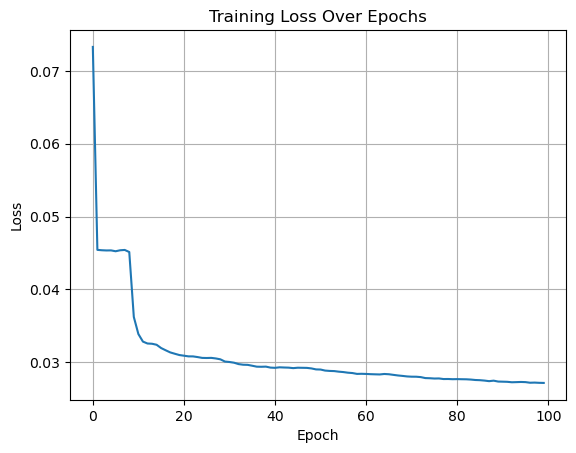

In [10]:
epochs = 100
losses = [] #added to store avg loss per epoch

for epoch in range(epochs):
    model.train()
    totalLoss = 0.0
    
    for inputs, targets in trainLoader:
        inputs  = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        reconstruction, _ = model(inputs)
        loss = criterion(reconstruction, targets)
        loss.backward()
        optimizer.step()
        totalLoss += loss.item()
        
    avgLoss = totalLoss / len(trainLoader)
    losses.append(avgLoss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avgLoss:.4f}")

    scheduler.step(avgLoss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"           → current LR: {current_lr:.5f}")

#for visualising the losses
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Validate Autoencoder Performance

Switch to evaluation mode, computes batch-wise reconstruction MSE on the validation set without gradients, aggregates losses to calculate average MSE and RMSE, and prints the metrics.


In [11]:
# Validate the model
model.eval()
valLoss = 0.0
with torch.no_grad():
   for inputs, targets in valLoader:
        inputs  = inputs.to(device)
        targets = targets.to(device)

        reconstruction, _ = model(inputs)
        loss = criterion(reconstruction, targets)
        valLoss += loss.item() * inputs.size(0)
        
avgValLoss = valLoss / len(valDataset)
rmse = avgValLoss ** 0.5
print(f"Validation MSE: {avgValLoss:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

Validation MSE: 0.0290
Validation RMSE: 0.1702


## Sanity Check Utilities

- Computes embeddings for all users and stores them in `userEmbeddings`
- `getlistOfUsernamesfromIndices(topIndices)`: return list of username from tensor of indices
- `getUserDetailsByIndex(userIndex)`: prints the user’s index and name  
- `getUserDetailsByIndices(userIndices,similarity):` lists users with their cosine similarity scores  
- `getTopKSimilarUsersFromIndex(userIndex, topK)`: retrieves and displays the top‑K similar users by index  
- `getTopKSimilarUsersFromBeers(beerIds, topK)`: transforms a list of beers into an embedding of "liked" beers and displays the top‑K similar users  


In [101]:
# utility methods
userMatrix = torch.tensor(X, dtype=torch.float).to(device)
model.eval()
with torch.no_grad():
    userEmbeddings = model.encoder(userMatrix)

def getlistOfUsernamesfromIndices(topIndices):
    usernames = []
    for index in userIndices:
        index = index.item()
        username  = df.iloc[index]['username']
        usernames.append(username)
    return usernames

def getUserDetailsByIndex(userIndex):
    username = df.iloc[userIndex]['username']
    print("Index:", userIndex, "Username:", username)
    return username

def getUserDetailsByIndices(userIndices,similarity):
    for index in userIndices:
        index = index.item()
        username  = df.iloc[index]['username']
        print(f"{index:5d} | {username:30s} | simlarity={similarity[index]:.3f}")

def getTopKSimilarUsersFromIndex(userIndex, topK):
    targetEmbedding = userEmbeddings[userIndex].unsqueeze(0)
    cosSim = F.cosine_similarity(targetEmbedding, userEmbeddings)
    cosSim[userIndex] = -1
    _, topIndices = torch.topk(cosSim, k=topK)
    getUserDetailsByIndices(topIndices, cosSim)
    return topIndices

def getTopKSimilarUsersFromBeers(beerIndices,topK):
    seedVector = torch.zeros(userMatrix.size(1), device=device)
    seedVector[beerIndices] = 1.0
    with torch.no_grad():
        seedEmbedding = model.encoder(seedVector.unsqueeze(0))  # (1, emb_dim)
    cosSim = F.cosine_similarity(seedEmbedding, userEmbeddings)  # (n_users,)
    _, topIndices = torch.topk(cosSim, k=topK)
    getUserDetailsByIndices(topIndices,cosSim)
    return topIndices

In [102]:
# utility methods to perform sanity checks
try:
    final = pd.read_csv('final_beers_reviews_breweries.csv')
except Exception as e:
    print(f"Error loading reviews.csv: {e}")

beerDetails = final.groupby('beer_id').agg({
    'name': 'first',
    'state': 'first',
    'country': 'first',
    'style': 'first',
    'availability': 'first',
    'abv': 'mean',
    'notes': 'first',
    'look': 'mean',
    'smell': 'mean',
    'taste': 'mean',
    'feel': 'mean',
    'overall': 'mean',
    'score': 'mean',
    'name_brewery': 'first',
    'city': 'first',
    'notes_brewery': 'first',
    'types': 'first'
}).reset_index()


def getBeerDetailsFromIds(beerIdList):
    df_idx = beerDetails.set_index('beer_id')
    df_out = df_idx.loc[beerIdList]
    return df_out.reset_index()

def getActualTopKReviewedBeersForUser(username, topK=10):
    userReviews = final[final['username'] == username]
    return userReviews.sort_values(by='score', ascending=False).head(topK)



## Inspect Cosine Similarity Distribution

Calls `getTopKSimilarUsersFromIndex(506, 500)` to compute and display cosine similarities between beer index 506 and top 500 similar users, printing a long range of similarity scores for a comprehensive sanity check. The cosine similarity did not collapse and it is displayed that there are distict differences among users.


In [103]:
userindex=1738
getUserDetailsByIndex(userindex)
getTopKSimilarUsersFromIndex(userindex,500)

Index: 1738 Username: ClashmoreMike
 1292 | BricksandPorter                | simlarity=0.975
 2552 | EmilNoldSinclair               | simlarity=0.964
13381 | norwichboy                     | simlarity=0.952
14821 | stoutlove77                    | simlarity=0.951
12646 | matt7215                       | simlarity=0.949
 5797 | PerroGrande                    | simlarity=0.948
 1199 | BrandonWardlaw                 | simlarity=0.946
 6182 | RichScherle                    | simlarity=0.944
 9594 | cleolicious                    | simlarity=0.941
 3273 | Herrbrokt                      | simlarity=0.941
 7898 | WildMaverick1200               | simlarity=0.940
 6709 | SingleCell                     | simlarity=0.938
 2670 | FatCaster                      | simlarity=0.937
14861 | sunrisesolara                  | simlarity=0.936
 2263 | Doiv                           | simlarity=0.936
13076 | mrbosworth                     | simlarity=0.932
15531 | vwahaszee                      | simlarity=0

tensor([ 1292,  2552, 13381, 14821, 12646,  5797,  1199,  6182,  9594,  3273,
         7898,  6709,  2670, 14861,  2263, 13076, 15531, 15359, 14613,  4788,
        15242, 12041,  8976,  5176, 12007, 10425, 11177,  5319,  6978, 13667,
        10107,  9611,  6102,  1502,   658,  4397,  1411, 11944,  3514,  1113,
          124,  2339,  8092, 14599,  1977,  2749,  8249, 14278, 14934, 13188,
         8669, 14551, 11542, 12796,  4760, 12042,  6345,  2025,  1126, 11979,
        14525, 10599, 10763,  1547,  6192, 12635,  8983,  8575,  4000,  2932,
         3710, 11783, 15476,  1966,  4742,  1546, 10163, 13081, 14873,  2576,
        14430, 11937,   904, 15114,  7574,  5423, 14241, 10543,  4611, 14674,
          517,  3017,   538,   114,  7491,  3664,  3980, 10715, 12049,  5226,
        11366,   281,  1461,  1117, 12716, 10013,  9192,  4898, 15593, 11676,
        10534,  7850,  6741, 14784,  1953,  9904,  5567, 15354,  4515, 14098,
        15789, 15410,  4268,  7077,  2208,   426, 10257,  4492, 

## Inspect Similarity Qualitatively:

A utility function `printActualTopKBeersOfMostSimilaruser` is defined. It is called to display the most similar user and visually compare the. The results produced frequently output users whose favourite beers are of similar styles.

In [104]:
def printActualTopKBeersOfMostSimilaruser(userindex, topK):
    print('Finding Similar user for :')
    currentUsername = getUserDetailsByIndex(userindex)
    print('Most Similar user:')
    mostSimilarUserIndex = getTopKSimilarUsersFromIndex(userindex,1)
    mostSimilarUsername = getUserDetailsByIndex(mostSimilarUserIndex.item())
    topbeers_selected_user = getActualTopKReviewedBeersForUser(currentUsername,topK)
    topbeers_top1_similar_user = getActualTopKReviewedBeersForUser(mostSimilarUsername,topK)
    print(' ')
    print(f"{currentUsername}: ")
    print(topbeers_selected_user[['name', 'style']].to_string(index=False))
    print(' ')
    print(f"{mostSimilarUsername}: ")
    print(topbeers_top1_similar_user[['name', 'style']].to_string(index=False))

In [105]:
import random

randomIndices = random.sample(range(15893 + 1), 5)
for ri in randomIndices:
    printActualTopKBeersOfMostSimilaruser(ri,10)
    print('====================================')
    print(' ')

Finding Similar user for :
Index: 5679 Username: PBRmeasap1980
Most Similar user:
 9770 | cubs943                        | simlarity=0.921
Index: 9770 Username: cubs943
 
PBRmeasap1980: 
                       name                   style
 Bourbon County Brand Stout American Imperial Stout
               Abrasive Ale   American Imperial IPA
Cantillon Kriek 100% Lambic    Belgian Fruit Lambic
   Hunahpu's Imperial Stout American Imperial Stout
            Pliny The Elder   American Imperial IPA
                Zombie Dust American Pale Ale (APA)
                 Pseudo Sue American Pale Ale (APA)
         Arctic Panzer Wolf   American Imperial IPA
            Dreadnaught IPA   American Imperial IPA
Cantillon Rosé De Gambrinus    Belgian Fruit Lambic
 
cubs943: 
                             name                   style
       Bourbon County Brand Stout American Imperial Stout
                         Darkness  Russian Imperial Stout
                         Parabola  Russian Imperial Sto

## Save Trained Autoencoder Model

Sets the model to evaluation mode, uses TorchScript to script (freeze) the autoencoder into `scripted_model`, and saves it as `user_autoencoder_frozen.pt` for efficient deployment and later inference.


In [98]:
# save trained model
model.eval()
scripted_model = torch.jit.script(model)
scripted_model.save("user_autoencoder_frozen.pt")

## Save User Embeddings

Moves the `userEmbeddings` tensor to CPU and persists it to `user_embeddings_autoencoder.pt` using `torch.save` for downstream recommendation inference.


In [99]:
# save trained userembeddings
userEmbeddings = userEmbeddings.cpu()       # move to CPU if on GPU/MPS
torch.save(userEmbeddings, "user_embeddings_autoencoder.pt")